In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU  # Usar GRU ao invés de LSTM

2024-09-06 15:44:40.168098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 15:44:40.182198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 15:44:40.198397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 15:44:40.202371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 15:44:40.216730: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Coleta de Dados Históricos (2 anos)
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(period="2y", interval="1h")  # Coleta de dados por hora

In [3]:
# Usar apenas a coluna 'Close' para previsão
data = btc_data[["Close"]]

In [4]:

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Criar as sequências para o modelo GRU
sequence_length = 60  # Usaremos 60 horas de histórico para prever a próxima hora
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length : i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Redimensionar X para ter a forma [amostras, sequência temporal, número de features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
# Obter as datas correspondentes para y
y_dates = btc_data.index[sequence_length:]

# Divisão dos Dados (80% treino, 20% teste)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
y_dates_train, y_dates_test = y_dates[:split], y_dates[split:]

In [7]:
# Construção do Modelo GRU
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(GRU(units=100))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

/home/rafa/pondm7/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Treinamento do modelo
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0063
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 2.3012e-05
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 2.5943e-05
Epoch 4/30
150/435 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 2.5266e-05

In [ ]:
# Fazer Previsões
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Ajustar o tamanho de y_test para corresponder ao tamanho de predicted_prices
real_prices = y_test[:len(predicted_prices)]
real_prices = scaler.inverse_transform(real_prices.reshape(-1, 1))

# Previsão das próximas 4 dias (96 horas)
last_sequence = X_test[-1]  # Última sequência do conjunto de teste
predictions = []

# Gerar previsões para as próximas 96 horas
for _ in range(96):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)[-sequence_length:]
    last_sequence = last_sequence.reshape(sequence_length, 1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Obter as datas para as próximas 96 horas
last_date = y_dates_test[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=96, freq='H')

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━

/tmp/ipykernel_25267/4245584068.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=96, freq='H')


In [ ]:
# Cálculo das Métricas do Modelo
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 3.99
Root Mean Squared Error (RMSE): 2.00
Mean Absolute Error (MAE): 1.65


In [ ]:
# Identificação dos Melhores Horários para Comprar e Vender
sell_hour_index = np.argmax(predictions)
buy_hour_index = np.argmin(predictions)

sell_hour = future_dates[sell_hour_index]
buy_hour = future_dates[buy_hour_index]

print(f"Melhor horário para vender Solana: {sell_hour}")
print(f"Melhor horário para comprar Solana: {buy_hour}")

Melhor horário para vender Solana: 2024-09-10 17:00:00+00:00
Melhor horário para comprar Solana: 2024-09-06 18:00:00+00:00


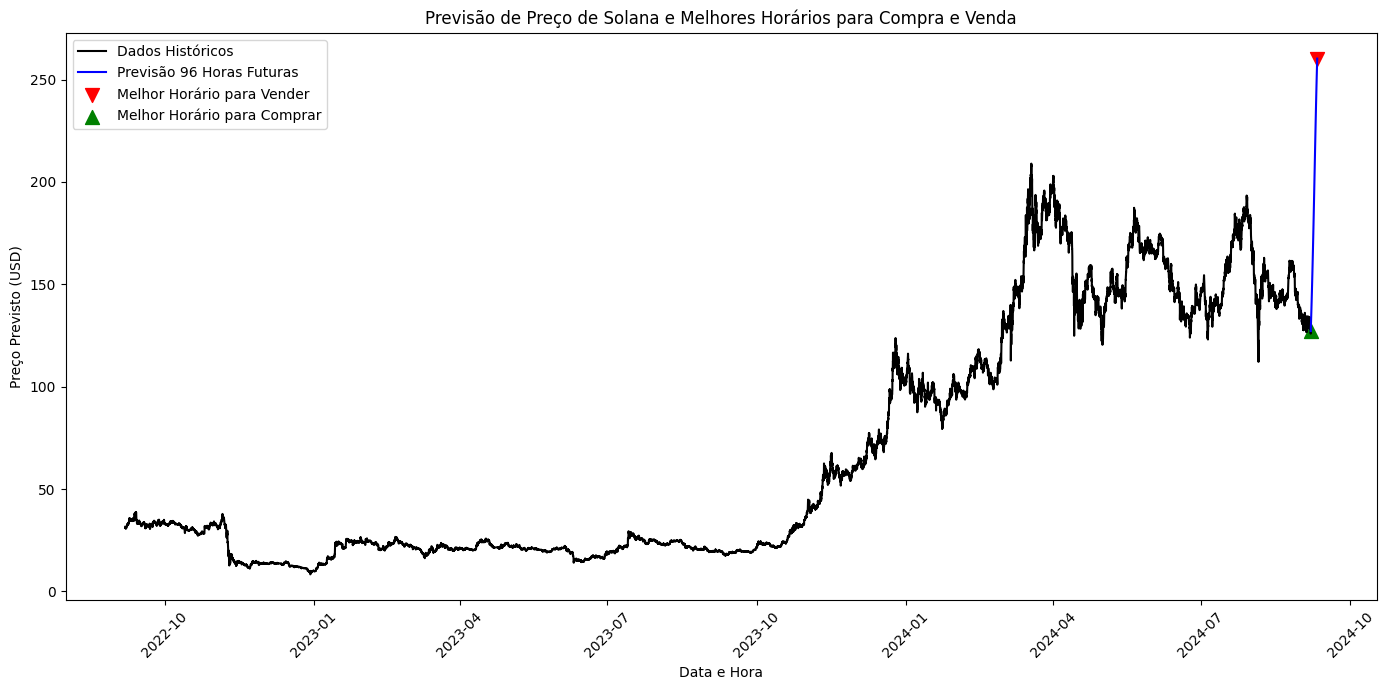

In [ ]:
# Gráfico mostrando a previsão para as próximas 96 horas comparada aos dados passados
plt.figure(figsize=(14, 7))

# Plotar os dados históricos de preços
plt.plot(btc_data.index, btc_data['Close'], label="Dados Históricos", color="black")

# Plotar as previsões futuras
plt.plot(future_dates, predictions, label="Previsão 96 Horas Futuras", color="blue")

# Marcar o melhor horário para vender
plt.scatter(sell_hour, predictions[sell_hour_index], color="red", label="Melhor Horário para Vender", marker="v", s=100)

# Marcar o melhor horário para comprar
plt.scatter(buy_hour, predictions[buy_hour_index], color="green", label="Melhor Horário para Comprar", marker="^", s=100)

plt.title("Previsão de Preço de Solana e Melhores Horários para Compra e Venda")
plt.xlabel("Data e Hora")
plt.ylabel("Preço Previsto (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

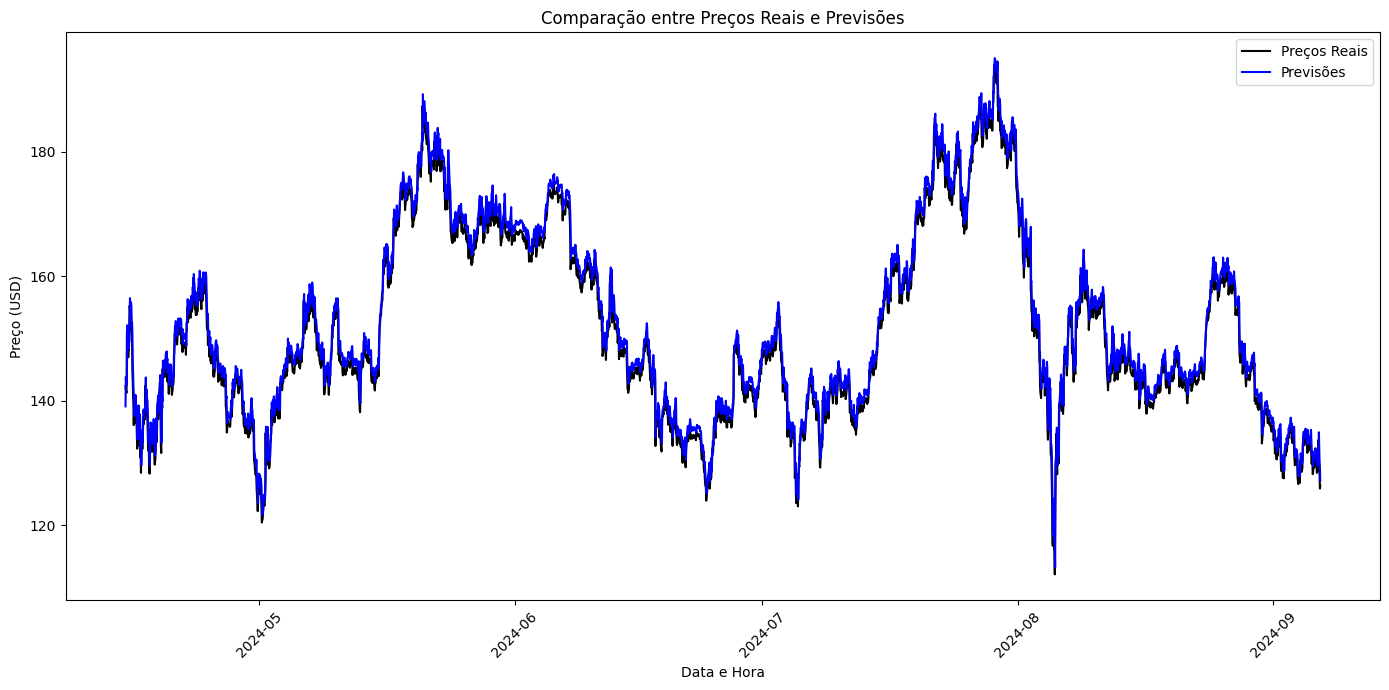

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_dates_test[:len(predicted_prices)], real_prices, color="black", label="Preços Reais")
plt.plot(y_dates_test[:len(predicted_prices)], predicted_prices, color="blue", label="Previsões")
plt.title("Comparação entre Preços Reais e Previsões")
plt.xlabel("Data e Hora")
plt.ylabel("Preço (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

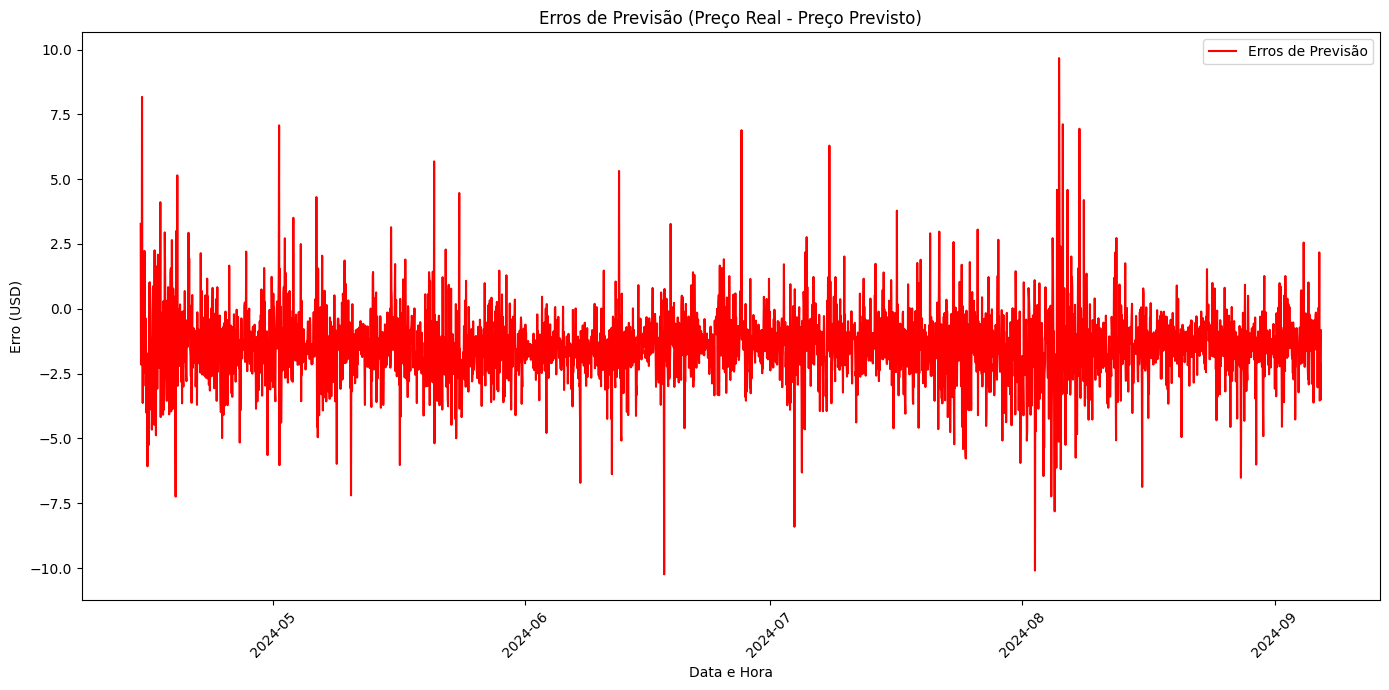

In [ ]:
errors = real_prices - predicted_prices

plt.figure(figsize=(14, 7))
plt.plot(y_dates_test[:len(errors)], errors, color="red", label="Erros de Previsão")
plt.title("Erros de Previsão (Preço Real - Preço Previsto)")
plt.xlabel("Data e Hora")
plt.ylabel("Erro (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

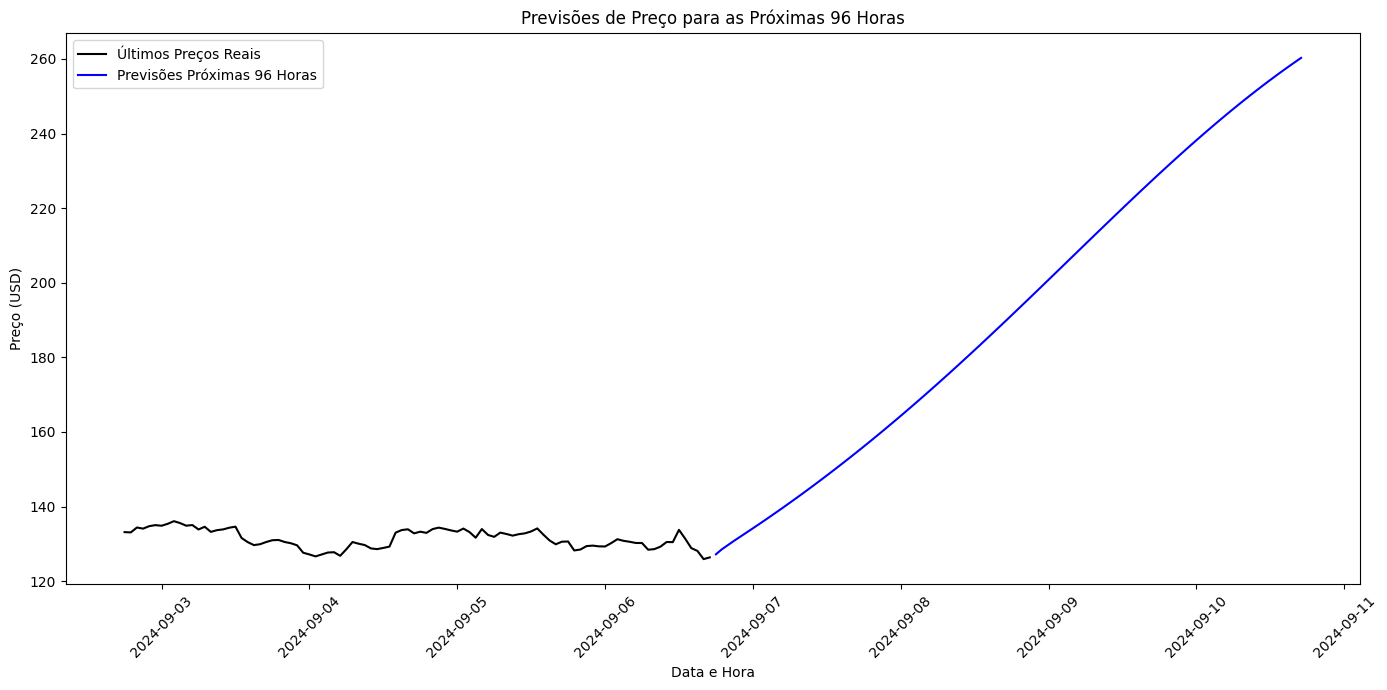

In [ ]:
plt.figure(figsize=(14, 7))

# Últimos preços reais de teste
plt.plot(y_dates_test[-96:], real_prices[-96:], label="Últimos Preços Reais", color="black")

# Previsões para as próximas 96 horas
plt.plot(future_dates, predictions, label="Previsões Próximas 96 Horas", color="blue")


plt.title("Previsões de Preço para as Próximas 96 Horas")
plt.xlabel("Data e Hora")
plt.ylabel("Preço (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

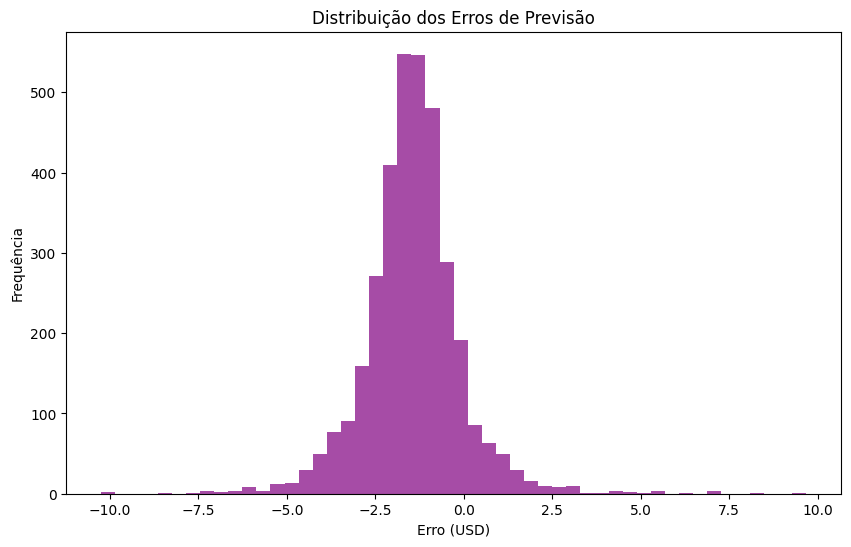

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color="purple", alpha=0.7)
plt.title("Distribuição dos Erros de Previsão")
plt.xlabel("Erro (USD)")
plt.ylabel("Frequência")
plt.show()

In [ ]:
# model.save('model_gru_btc.h5')